In [1]:
"""

"""


import pandas
import pylab
import numpy
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler, normalize
# import scipy
# import scipy.stats as stats
import seaborn

import matplotlib.pyplot as pyplot
import pylab
%matplotlib inline


## Задачи исследования
1. Отличаются ли пелены от бинтов по параметрам?
2. Отличаются ли узкие, средние и широкие бинты друг от друга по параметрам?
3. Каков процент рогожки?
4. Какие группы тканей по качеству получаются?
5. Различаются ли нити основы и нити утка?
6. Какое количество (процент) тканей высокого качества имеют сбалансированное переплетение?
7. Какое количество (процент) тканей среднего качества имеет сбалансированное переплетение?
8. Какое количество (процент) тканей ниского качества имеет сбалансированное переплетение?
9. Каково соотношение сбалансированных тканей и тканей с преобладанием нитей основы?
10. Высчитать "коэффициент заполняемости" тканей
11. Разделить ткани по сбалансированности (сбалансированные - ±3 нити; ткани с преобладанием нитей основы); рассчитать процент каждой группы

### Список переменных
1. textiles - полный датафрейм, очищенный только от пропусков
2. textiles_cleared_thick - датафрейм, очищенный от выбросов по толщинам нитей
3. textiles_cleared_dens - датафрейм, очищенный от выбросов по плотностям тканей
4. textiles_cleared - датафрейм, очищенный от выбросов по плотностям тканей и толщинам нитей
5. outliers_thick - датафрейм выбросов по толщинам нитей
6. outliers_dens - датафрейм выбросов по плотности ткани
7. narrow_bands - датафрейм - только узкие бинты
8. middle_bands - датафрейм - только средние бинты
9. wide_bands - датафрейм - только широкие бинты
10. quartile_thick_warp_1 - первый квартиль по толщине по основе
11. quartile_thick_warp_2 - второй квартиль по толщине по основе
12. quartile_thick_warp_3 - третий квартиль по толщине по основе
13. quartile_thick_weft_1 - первый квартиль по толщине по утку
14. quartile_thick_weft_2 - второй квартиль по толщине по утку
15. quartile_thick_weft_3 - третий квартиль по толщине по утку
16. quartile_dens_warp_1 - первый квартиль по плотности по основе
17. quartile_dens_warp_2 - второй квартиль по плотности по основе
18. quartile_dens_warp_3 - третий квартиль по плотности по основе
19. quartile_dens_weft_1 - первый квартиль по плотности по утку
20. quartile_dens_weft_2 - второй квартиль по плотности по утку
21. quartile_dens_weft_3 - третий квартиль по плотности по утку

In [2]:
def convert_to_float(value):
    """
    Преобразование значений в столбцах датафрейма;
    :param value: float
    :return: float
    """
    value = str(value)
    value = value.replace(",", ".")
    value = round(float(value), 2)
    return value

#######################################################################################################################


### Загрузка и предобработка данных

In [42]:

# Загрузка датафрейма из CSV файла;
textiles = pandas.read_csv('dataframe.csv')

len_textiles_base = len(textiles)
textiles = textiles.dropna(subset=['warp_dens', 'weft_dens'])
len_textiles = len(textiles)

########################################################################################################################

# Приведение типов колонок датафрейма к значению с плавающей запятой;
textiles['warp_a'] = textiles.warp_a.apply(convert_to_float)
textiles['warp_b'] = textiles.warp_b.apply(convert_to_float)
textiles['weft_a'] = textiles.weft_a.apply(convert_to_float)
textiles['weft_b'] = textiles.weft_b.apply(convert_to_float)

########################################################################################################################

# Вычисление "усредненных" толщин нитей;
textiles['warp_nominal'] = round((textiles['warp_a'] + textiles['warp_b']) / 2, 2)
textiles['weft_nominal'] = round((textiles['weft_a'] + textiles['weft_b']) / 2, 2)

########################################################################################################################

# Соотношение плотностей по основе и утку;
textiles['warp_weft'] = round((textiles['warp_dens'] / textiles['weft_dens']), 2)

########################################################################################################################

# Добавление признака density_coefficient;
textiles['density_coefficient'] = round((textiles['warp_dens'] / textiles['weft_dens']), 2)

########################################################################################################################

print()
# print(textiles.head())
print()
print("Общее количество записей - " + str(len_textiles), end="\n\n\n")




Общее количество записей - 303




In [43]:
print(textiles.head())

   order grave  add    z internal_storage  number warp_size  weft_size  \
0    1.0    80  0.0  0.0    2007-0075-002     NaN       100        110   
1    2.0    80  0.0  0.0    2007-0075-003     NaN       290         40   
2    3.0    86  0.0  0.0    2007-0056-003     NaN       140         90   
3    4.0    86  0.0  1.0    2007-0056-004     NaN       300         20   
4    5.0    87  0.0  1.0    2007-0059-001     NaN       420         20   

     type  item_no  ... warp_thick_mean weft_a weft_b weft_mean warp_dens  \
0  fabric        0  ...            0,75    0.5    1.0      0,75      13.0   
1  n_band        0  ...             0,4    0.6    0.8       0,7      16.0   
2  fabric        0  ...             0,5    0.1    0.2      0,15      18.0   
3  n_band        0  ...            0,35    0.2    0.6       0,4      30.0   
4  n_band        0  ...             0,5    0.5    0.6      0,55      24.0   

  weft_dens warp_nominal weft_nominal warp_weft density_coefficient  
0       8.0         0.

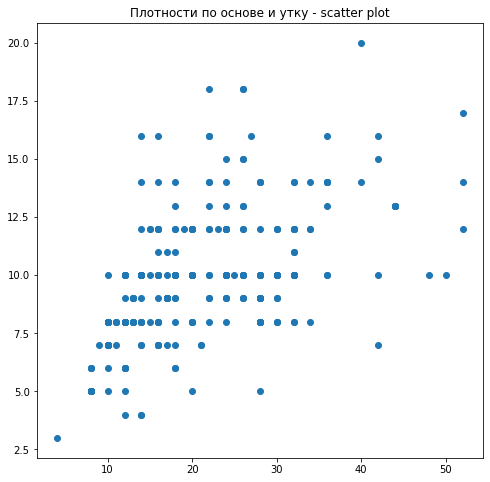

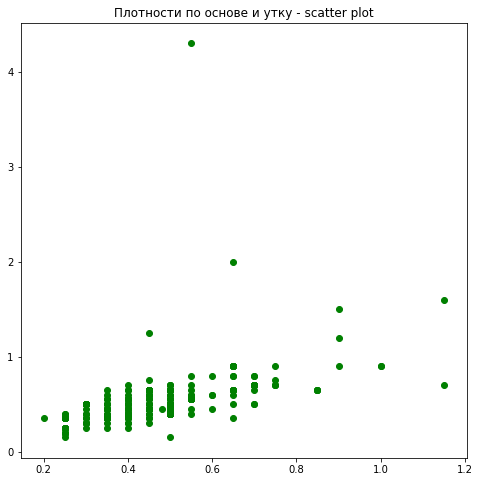

In [41]:
########################################################################################################################

fig, ax = pyplot.subplots(figsize=[8, 8])
pyplot.scatter(textiles['warp_dens'].tolist(), textiles['weft_dens'].tolist())
pyplot.title('Плотности по основе и утку - scatter plot')
pyplot.show()

print("\n\n")

########################################################################################################################

fig, ax = pyplot.subplots(figsize=[8, 8])
ax = pyplot.scatter(textiles['warp_nominal'].tolist(), textiles['weft_nominal'].tolist(), color='green')
pyplot.title('Плотности по основе и утку - scatter plot')
pyplot.show()

########################################################################################################################

### Вычисление квартилей

In [4]:
# Список получаемых переменных:
#
# quartile_thick_warp_1 - первый квартиль по толщине по основе
# quartile_thick_warp_2 - второй квартиль по толщине по основе
# quartile_thick_warp_3 - третий квартиль по толщине по основе
#
# quartile_thick_weft_1 - первый квартиль по толщине по утку
# quartile_thick_weft_2 - второй квартиль по толщине по утку
# quartile_thick_weft_3 - третий квартиль по толщине по утку
#
# quartile_dens_warp_1 - первый квартиль по плотности по основе
# quartile_dens_warp_2 - второй квартиль по плотности по основе
# quartile_dens_warp_3 - третий квартиль по плотности по основе
#
# quartile_dens_weft_1 - первый квартиль по плотности по утку
# quartile_dens_weft_2 - второй квартиль по плотности по утку
# quartile_dens_weft_3 - третий квартиль по плотности по утку


# квартили толщин нитей по основе;
quartile_thick_warp_1, quartile_thick_warp_2, quartile_thick_warp_3 = textiles['warp_nominal'].quantile([0.25, 0.5, 0.75])
quartile_thick_warp_1 = round(quartile_thick_warp_1, 2)
quartile_thick_warp_2 = round(quartile_thick_warp_2, 2)
quartile_thick_warp_3 = round(quartile_thick_warp_3, 2)

########################################################################################################################

# квартили толщин нитей по утку;
quartile_thick_weft_1, quartile_thick_weft_2, quartile_thick_weft_3 = textiles['weft_nominal'].quantile([0.25, 0.5, 0.75])
quartile_thick_weft_1 = round(quartile_thick_weft_1, 2)
quartile_thick_weft_2 = round(quartile_thick_weft_2, 2)
quartile_thick_weft_3 = round(quartile_thick_weft_3, 2)

########################################################################################################################

# квартили плотности по основе;
quartile_dens_warp_1, quartile_dens_warp_2, quartile_dens_warp_3 = textiles['warp_dens'].quantile([0.25, 0.5, 0.75])
quartile_dens_warp_1 = round(quartile_dens_warp_1, 2)
quartile_dens_warp_2 = round(quartile_dens_warp_2, 2)
quartile_dens_warp_3 = round(quartile_dens_warp_3, 2)

########################################################################################################################

# квартили плотности по утку;
quartile_dens_weft_1, quartile_dens_weft_2, quartile_dens_weft_3 = textiles['weft_dens'].quantile([0.25, 0.5, 0.75])
quartile_dens_weft_1 = round(quartile_dens_weft_1, 2)
quartile_dens_weft_2 = round(quartile_dens_weft_2, 2)
quartile_dens_weft_3 = round(quartile_dens_weft_3, 2)

########################################################################################################################

print()
print()
print("Квартили толщины по основе - " + 
      str(quartile_thick_warp_1) + ' ' + str(quartile_thick_warp_2) + ' ' + str(quartile_thick_warp_3))
print("Квартили толщины по утку - " + 
      str(quartile_thick_weft_1) + ' ' + str(quartile_thick_weft_2) + ' ' + str(quartile_thick_weft_3))
print("Квартили плотности по основе - " + 
      str(quartile_dens_warp_1) + ' ' + str(quartile_dens_warp_2) + ' ' + str(quartile_dens_warp_3))
print("Квартили плотности по утку - " + 
      str(quartile_dens_weft_1) + ' ' + str(quartile_dens_weft_2) + ' ' + str(quartile_dens_weft_3))




Квартили толщины по основе - 0.4 0.45 0.5
Квартили толщины по утку - 0.4 0.5 0.6
Квартили плотности по основе - 14.0 20.0 28.0
Квартили плотности по утку - 8.0 10.0 12.0


### Описание полного набора данных

In [5]:
textiles_warp_thick_mean = round(textiles['warp_nominal'].mean(), 3)
textiles_warp_thick_median = round(textiles['warp_nominal'].median(), 3)
textiles_weft_thick_mean = round(textiles['weft_nominal'].mean(), 3)
textiles_weft_thick_median = round(textiles['weft_nominal'].median(), 3)

########################################################################################################################

print()
print("Толщина по основе - среднее значение - " + str(textiles_warp_thick_mean))
print("Толщина по основе - медиана - " + str(textiles_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(textiles_weft_thick_mean))
print("Толщина по утку - медиана - " + str(textiles_weft_thick_median))

########################################################################################################################

textiles_warp_dens_mean = round(textiles['warp_dens'].mean(), 3)
textiles_warp_dens_median = round(textiles['warp_dens'].median(), 3)
textiles_weft_dens_mean = round(textiles['weft_dens'].mean(), 3)
textiles_weft_dens_median = round(textiles['weft_dens'].median(), 3)

########################################################################################################################

print()
print("Плотность по основе - среднее значение - " + str(textiles_warp_dens_mean))
print("Плотность по основе - медиана - " + str(textiles_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(textiles_weft_dens_mean))
print("Плотность по утку - медиана - " + str(textiles_weft_dens_median))


Толщина по основе - среднее значение - 0.471
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.53
Толщина по утку - медиана - 0.5

Плотность по основе - среднее значение - 21.231
Плотность по основе - медиана - 20.0
Плотность по утку - среднее значение - 9.851
Плотность по утку - медиана - 10.0


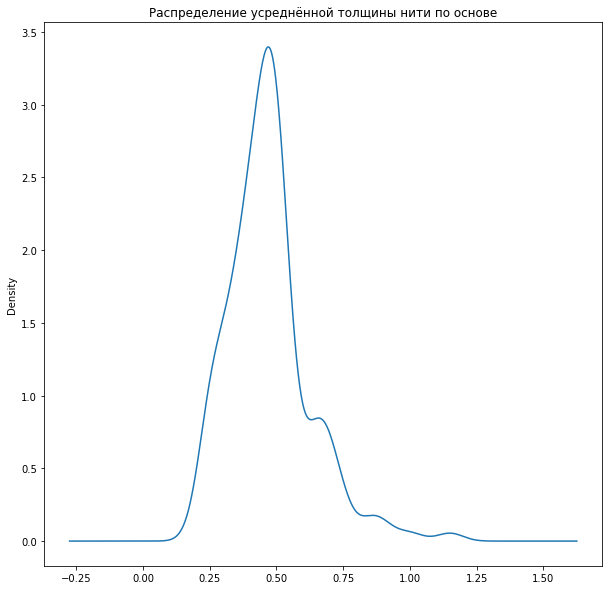

In [6]:
warp_thick = textiles['warp_nominal']
warp_thick.plot.kde(title='Распределение усреднённой толщины нити по основе', figsize=[10, 10])

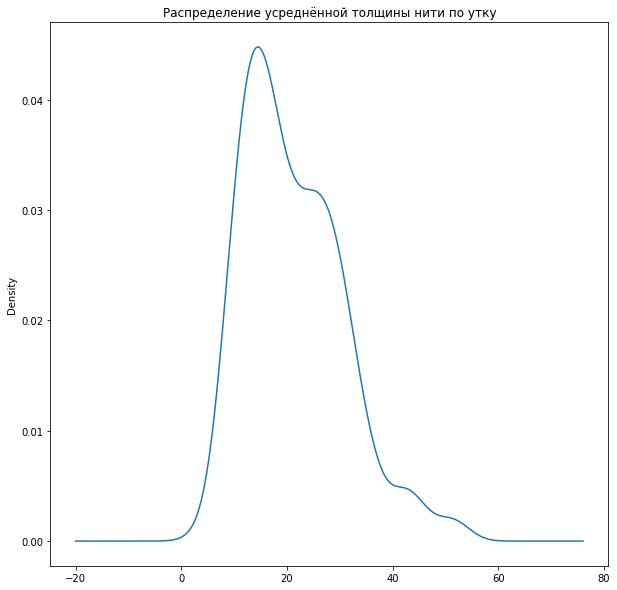

In [7]:
warp_density = textiles['warp_dens']
warp_density.plot.kde(title='Распределение усреднённой толщины нити по утку', figsize=[10, 10])

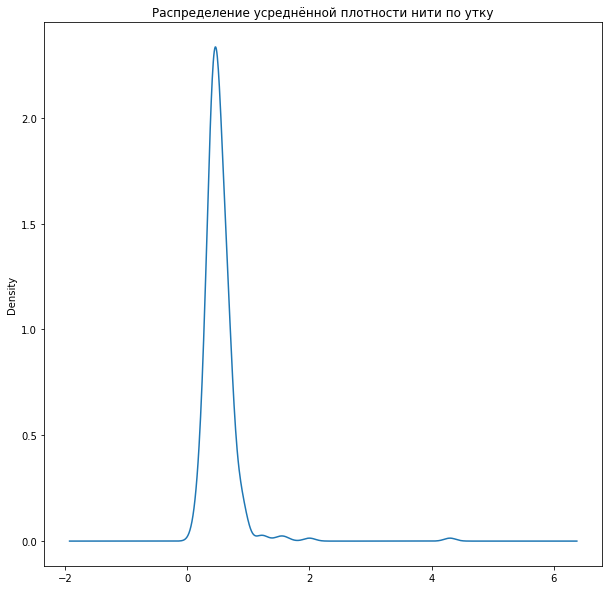

In [8]:
weft_thick = textiles['weft_nominal']
weft_thick.plot.kde(title='Распределение усреднённой плотности нити по утку', figsize=[10, 10])

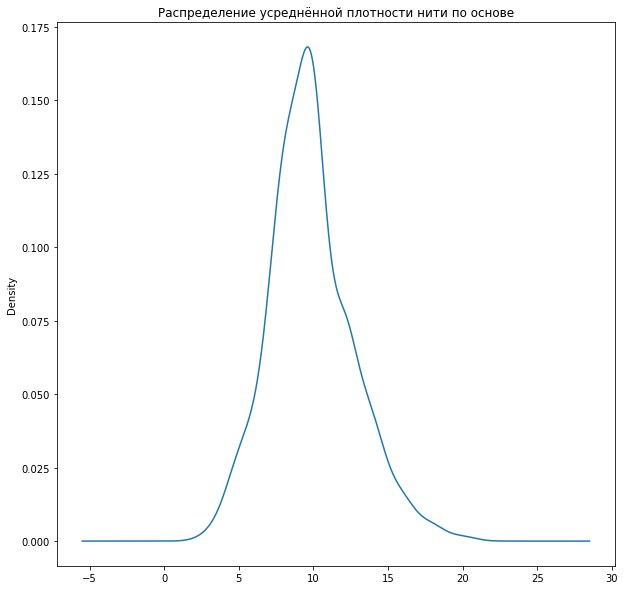

In [9]:
weft_dens = textiles['weft_dens']
weft_dens.plot.kde(title='Распределение усреднённой плотности нити по основе', figsize=[10, 10])

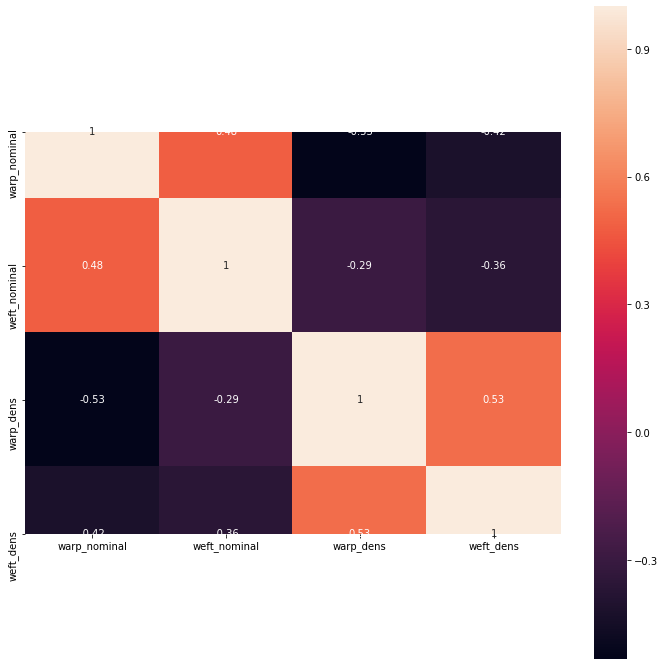

In [10]:

########################################################################################################################

fig, ax = pyplot.subplots(figsize=[12, 12])
seaborn.heatmap(textiles[['warp_nominal', 'weft_nominal', 'warp_dens', 'weft_dens']].corr(), square=True, annot=True)

########################################################################################################################


### Вычисление "выбросов" в данных

In [11]:
# Описание получаемых переменных:
#
# textiles_cleared_thick - датафрейм, очищенный от выбросов по толщине
# textiles_cleared_dens - датафрейм, очищенный от выбросов по плотности


# Выбросы по толщинам нитей по основе;
textiles_cleared_thick = \
    textiles[textiles.warp_nominal < 
             (quartile_thick_warp_3 + 1.5 * (quartile_thick_warp_3 + quartile_thick_warp_1))]
textiles_cleared_thick = \
    textiles_cleared_thick[textiles_cleared_thick.warp_nominal > 
                     (quartile_thick_warp_1 - 1.5 * (quartile_thick_warp_3 - quartile_thick_warp_1))]

########################################################################################################################

textiles_cleared_thick.to_csv('output/cleared_thick.csv')

########################################################################################################################

# Выбросы по плотности ткани по основе;
textiles_cleared_dens = \
    textiles[textiles.warp_dens <
             (quartile_dens_warp_1 + 1.5 * (quartile_dens_warp_3 - quartile_dens_warp_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.warp_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.weft_dens <
                          (quartile_dens_weft_1 + 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared_dens = \
    textiles_cleared_dens[textiles_cleared_dens.weft_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

########################################################################################################################

textiles_cleared_dens.to_csv('output/cleared_dens.csv')

########################################################################################################################

textiles_cleared = \
    textiles[textiles.warp_nominal < 
             (quartile_thick_warp_3 + 1.5 * (quartile_thick_warp_3 + quartile_thick_warp_1))]
textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_nominal > 
                     (quartile_thick_warp_1 - 1.5 * (quartile_thick_warp_3 - quartile_thick_warp_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_dens <
             (quartile_dens_warp_1 + 1.5 * (quartile_dens_warp_3 - quartile_dens_warp_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.warp_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.weft_dens <
                          (quartile_dens_weft_1 + 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

textiles_cleared = \
    textiles_cleared[textiles_cleared.weft_dens >
                          (quartile_dens_weft_1 - 1.5 * (quartile_dens_weft_3 - quartile_dens_weft_1))]

########################################################################################################################

textiles_cleared.to_csv('output/textiles_cleared.csv')

########################################################################################################################

# Датафрейм - только выбросы по толщинам нитей по основе;
outliers_thick = textiles[~textiles.index.isin(textiles_cleared_thick.index)]
outliers_dens = textiles[~textiles.index.isin(textiles_cleared_dens.index)]

########################################################################################################################

print()
print("Выбросов по толщине нити - " + str(len(outliers_thick)))
print("Выбросов по плотности тканей - " + str(len(outliers_dens)))
print("Размерность набора данных без учета выбросов - " + str(len(textiles_cleared)))
print()
print()



Выбросов по толщине нити - 26
Выбросов по плотности тканей - 47
Размерность набора данных без учета выбросов - 245




In [12]:
# warp_thick_outliers = outliers_thick['warp_nominal']
# warp_thick_outliers.plot.kde()

In [13]:
# warp_dens_outliers = outliers_thick['warp_dens']
# warp_dens_outliers.plot.kde()

### Иерархическая кластеризация

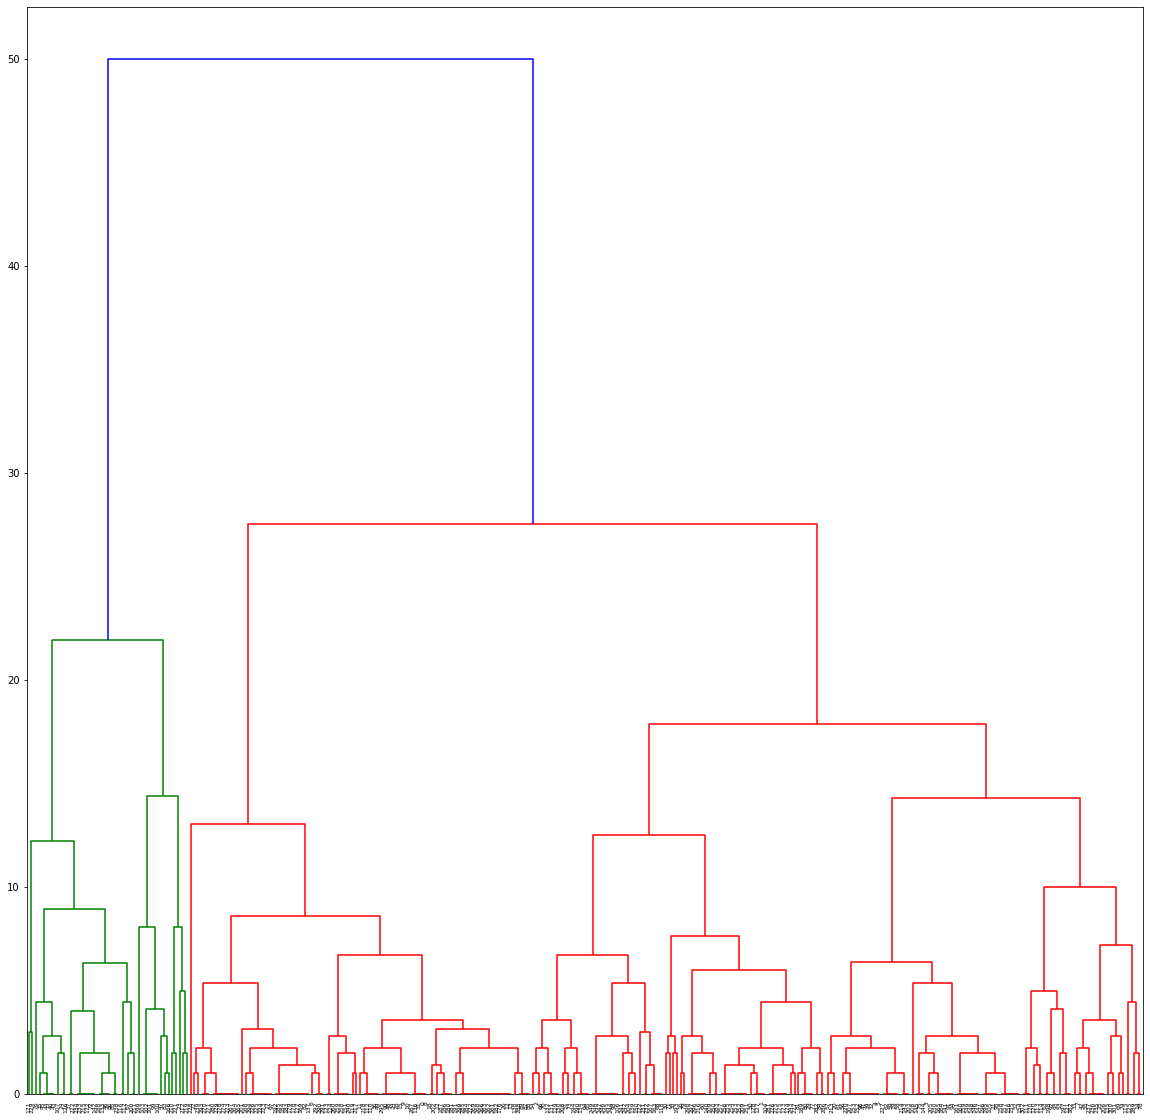

[[  0.           8.           0.           2.        ]
 [  1.         104.           0.           2.        ]
 [  2.          66.           0.           2.        ]
 ...
 [596.         600.          21.9317122   44.        ]
 [598.         601.          27.51363298 259.        ]
 [602.         603.          50.         303.        ]]


In [14]:
dens_warp_list = textiles['warp_dens'].tolist()
dens_weft_list = textiles['weft_dens'].tolist()

thick_warp_nominal_list = textiles['warp_nominal'].tolist()
thick_weft_nominal_list = textiles['weft_nominal'].tolist()

warp_weft_dens_list = []
for index, item in enumerate(dens_warp_list):\
    warp_weft_dens_list.append((dens_warp_list[index], dens_weft_list[index]))

mergings = linkage(warp_weft_dens_list, method='complete')
fig, ax = pyplot.subplots(figsize=[20, 20])
dendrogram(mergings, leaf_rotation=90, leaf_font_size=6, ax=ax)
pyplot.show()
print(mergings)

## Кластеризация

### Подготовка данных

In [15]:

########################################################################################################################

# Список кортежей для полной выборки

dens_warp_list = textiles['warp_dens'].tolist() # список значений плотности по основе
dens_weft_list = textiles['weft_dens'].tolist() # список значений плотности по утку

thick_warp_nominal_list = textiles['warp_nominal'].tolist()
thick_weft_nominal_list = textiles['weft_nominal'].tolist()

warp_weft_dens_list = []
for index, item in enumerate(dens_warp_list):\
    warp_weft_dens_list.append((dens_warp_list[index], dens_weft_list[index]))
    
print('\nРазмерность полученного списка - (полная выборка)' + str(len(warp_weft_dens_list)), end='\n')

########################################################################################################################



Размерность полученного списка - (полная выборка)303


In [16]:

########################################################################################################################

numeric_values_list = []

for index, _ in enumerate(dens_warp_list):
    numeric_values_list.append(
        [dens_warp_list[index], dens_weft_list[index], thick_warp_nominal_list[index], thick_weft_nominal_list[index]]
    )

########################################################################################################################


In [17]:
# Кластеризация с помощью K-Means - полная выборка

########################################################################################################################

kmeans = KMeans(n_clusters=3)

kmeans.fit(warp_weft_dens_list)
predictions = kmeans.predict(warp_weft_dens_list)
print("Полученные номера кластеров (k-means, полная выборка) - \n" + str(predictions), end="\n\n\n")

########################################################################################################################


Полученные номера кластеров (k-means, полная выборка) - 
[1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 2 0 0 1 1 1 1 1 1 0 0 1 2 1
 0 1 0 2 0 0 2 2 2 0 2 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1
 0 0 2 1 0 1 1 1 1 2 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 2 2 2 2 2 1 0 1 0 0 1 1
 0 1 0 0 0 2 2 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 2 1 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 0 0 0 0 2 0 1 1 0 0 0 0 0 1 1 2 0 2 0 0 0 1 1 1 2 0 2
 0 1 1 1 1 0 1 2 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 0 0 0]




In [18]:
# Список кортежей для выборки, очищенной от выбросов

########################################################################################################################

dens_warp_list_cleared = textiles_cleared['warp_dens'].tolist()
dens_weft_list_cleared = textiles_cleared['weft_dens'].tolist()

thick_warp_nominal_list = textiles_cleared['warp_nominal'].tolist()
thick_weft_nominal_list = textiles_cleared['weft_nominal'].tolist()

warp_weft_dens_list_cleared = []

for index, item in enumerate(dens_warp_list_cleared):\
    warp_weft_dens_list_cleared.append((dens_warp_list_cleared[index], dens_weft_list_cleared[index]))

########################################################################################################################


In [19]:

########################################################################################################################

numeric_values_cleared = []
for index, _ in enumerate(warp_weft_dens_list_cleared):
    numeric_values_cleared.append([dens_warp_list_cleared[index], dens_weft_list_cleared[index], thick_warp_nominal_list[index], thick_weft_nominal_list[index]])
    
print('\nРазмерность полученного списка - (выборка без выбросов)' + str(len(numeric_values_cleared)), end='\n\n\n')

########################################################################################################################



Размерность полученного списка - (выборка без выбросов)245




In [20]:
# Кластеризация с помощью K-Means - выборка, очищенная от выбросов

kmeans_cleared = KMeans(n_clusters=3)

kmeans_cleared.fit(numeric_values_cleared)
predictions_cleared = kmeans_cleared.predict(numeric_values_cleared)
print("Полученные номера кластеров (k-means, без выбросов по плотности ткани) - \n" + str(predictions_cleared), end="\n\n\n")

########################################################################################################################

Полученные номера кластеров (k-means, без выбросов по плотности ткани) - 
[0 2 2 1 1 1 0 2 0 0 0 0 2 2 0 2 0 1 1 1 0 1 1 2 0 0 2 0 1 1 0 0 1 1 2 1 0
 2 2 1 1 2 1 1 1 1 1 2 1 1 1 2 2 2 1 2 2 1 2 1 2 2 2 0 2 1 1 0 0 0 0 1 0 2
 1 1 2 0 0 2 0 1 2 0 0 1 2 2 2 2 2 2 1 2 2 0 2 2 2 1 1 1 1 1 1 1 1 1 2 0 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 2 0 0 1 2 2 2 2 0 0 0 0 0 2 0 0 0 0 0 1 2 2 2 0
 2 1 1 1 1 0 0 1 2 1 1 1 2 2 1 1 1 1 2 0 0 1 0 0 0 0 1 0 1 2 2 1 1 1 1 1 1
 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 2 2 2 0 0 2 0 2 2 0 0 2 0 0 2
 2 2 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2]




In [21]:

# Основной датафрейм - колонка с полученными номерами кластеров

textiles['kmeans_dens'] = predictions
textiles_cleared['kmeans_dens'] = predictions_cleared



ПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)



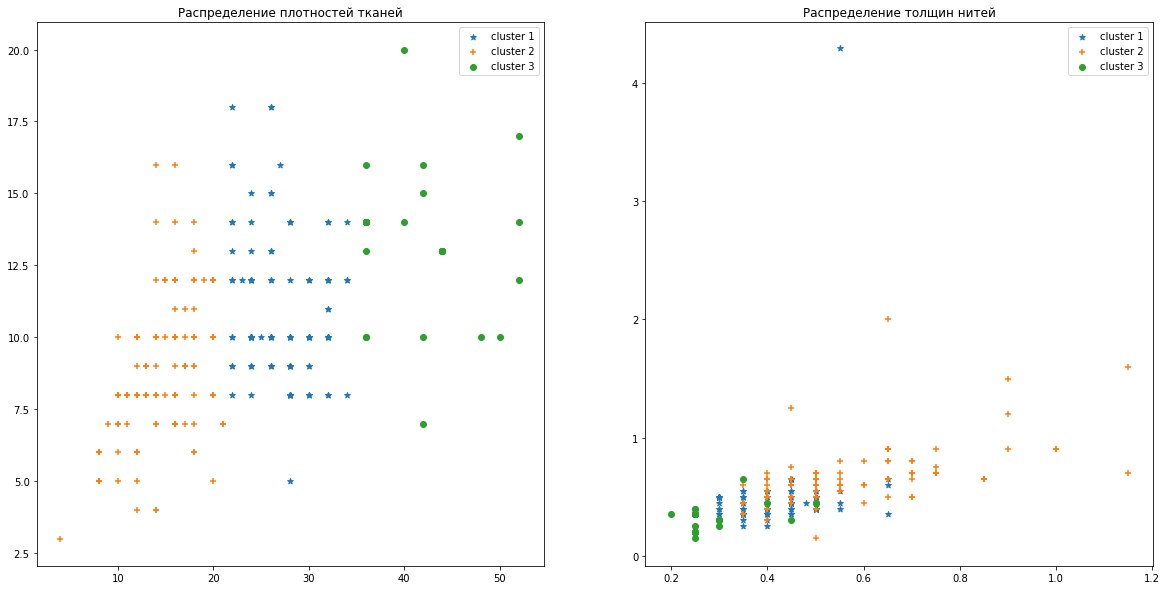



ДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ



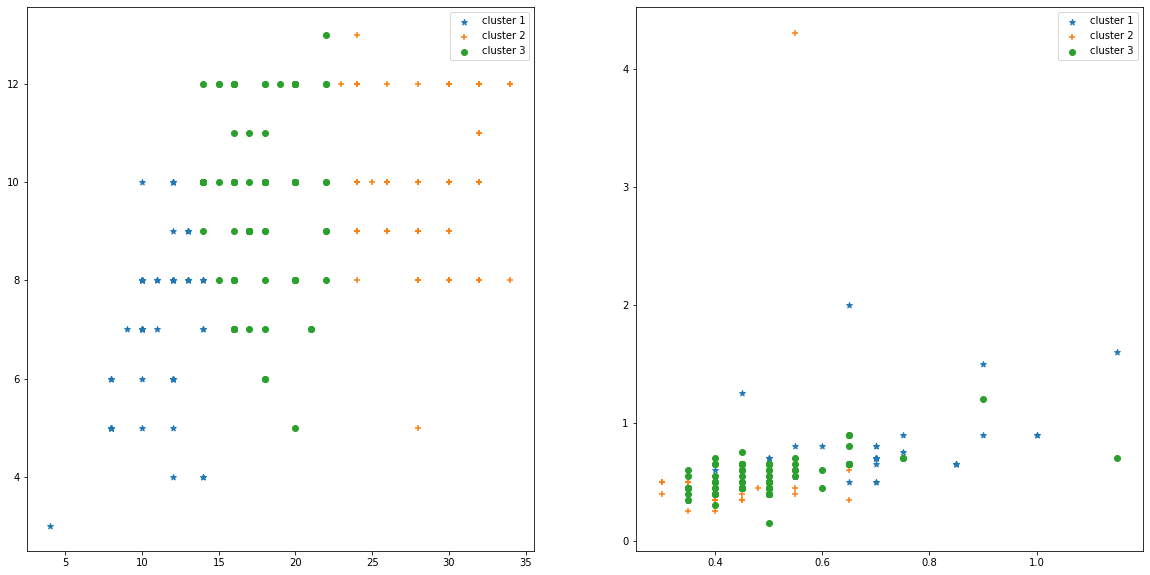

In [22]:

# График - отображение полученных кластеров

########################################################################################################################

print("\nПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)\n")

_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[20, 10])
axes[0].scatter(textiles.query('kmeans_dens == 0')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles.query('kmeans_dens == 1')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes[0].scatter(textiles.query('kmeans_dens == 2')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].set_title("Распределение плотностей тканей")
axes[0].legend()
axes[1].scatter(textiles.query('kmeans_dens == 0')['warp_nominal'].tolist(),
                         textiles.query('kmeans_dens == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles.query('kmeans_dens == 1')['warp_nominal'].tolist(),
                         textiles.query('kmeans_dens == 1')['weft_nominal'].tolist(), marker='+', label="cluster 2")
axes[1].scatter(textiles.query('kmeans_dens == 2')['warp_nominal'].tolist(),
                         textiles.query('kmeans_dens == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].set_title("Распределение толщин нитей")
axes[1].legend()
pyplot.show()


print("\n\nДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ\n")
_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[20, 10])
axes[0].scatter(textiles_cleared.query('kmeans_dens == 0')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles_cleared.query('kmeans_dens == 1')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes[0].scatter(textiles_cleared.query('kmeans_dens == 2')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].legend()
axes[1].scatter(textiles_cleared.query('kmeans_dens == 0')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_dens == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles_cleared.query('kmeans_dens == 1')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_dens == 1')['weft_nominal'].tolist(), marker='+', label="cluster 2")
axes[1].scatter(textiles_cleared.query('kmeans_dens == 2')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_dens == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].legend()
pyplot.show()

### Кластеризация методом к-средних на 2 кластера

In [23]:
kmeans_2 = KMeans(n_clusters=3)

kmeans_2.fit(warp_weft_dens_list)
predictions_2 = kmeans.predict(warp_weft_dens_list)

In [24]:
kmeans_cleared_2 = KMeans(n_clusters=3)

kmeans_cleared_2.fit(numeric_values_cleared)
predictions_cleared_2 = kmeans_cleared.predict(numeric_values_cleared)

In [25]:
textiles['kmeans_dens_2'] = predictions_2
textiles_cleared['kmeans_dens_2'] = predictions_cleared_2


ПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)



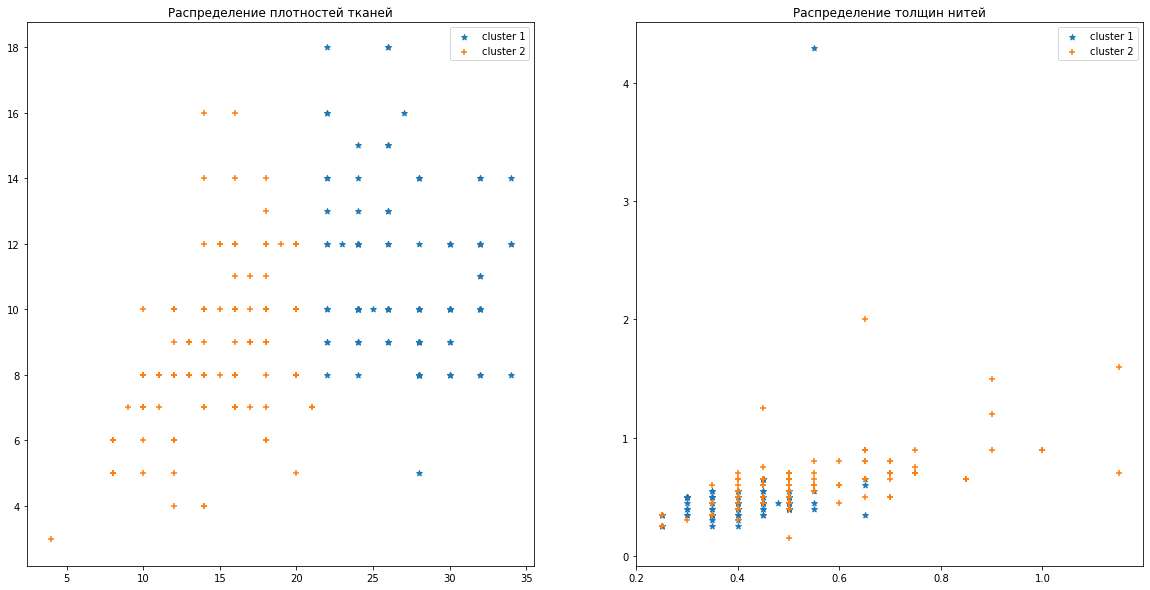



ДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ



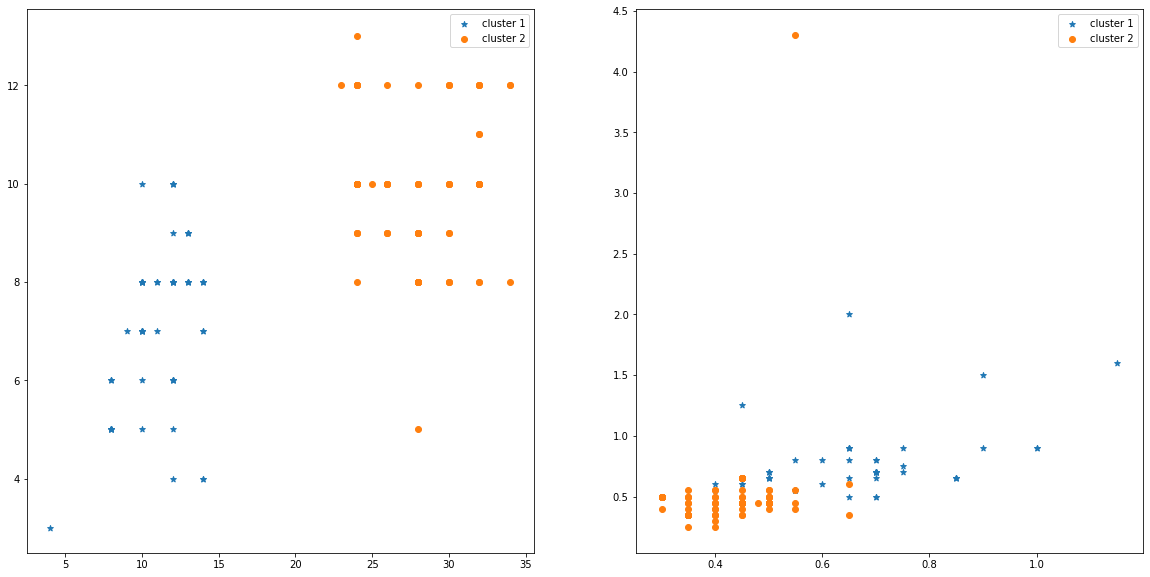

In [26]:

# График - отображение полученных кластеров

########################################################################################################################

print("\nПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)\n")

_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[20, 10])
axes[0].scatter(textiles.query('kmeans_dens_2 == 0')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens_2 == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles.query('kmeans_dens_2 == 1')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens_2 == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
# axes[0].scatter(textiles.query('kmeans_dens_2 == 2')['warp_dens'].tolist(),
#                          textiles.query('kmeans_dens_2 == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].set_title("Распределение плотностей тканей")
axes[0].legend()
axes[1].scatter(textiles.query('kmeans_dens_2 == 0')['warp_nominal'].tolist(),
                         textiles.query('kmeans_dens_2 == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles.query('kmeans_dens_2 == 1')['warp_nominal'].tolist(),
                         textiles.query('kmeans_dens == 1')['weft_nominal'].tolist(), marker='+', label="cluster 2")
# axes[1].scatter(textiles.query('kmeans_dens_2 == 2')['warp_nominal'].tolist(),
#                          textiles.query('kmeans_dens_2 == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].set_title("Распределение толщин нитей")
axes[1].legend()
pyplot.show()


print("\n\nДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ\n")
_, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[20, 10])
axes[0].scatter(textiles_cleared.query('kmeans_dens_2 == 0')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes[0].scatter(textiles_cleared.query('kmeans_dens_2 == 1')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 1')['weft_dens'].tolist(), marker='o', label="cluster 2")
# axes[0].scatter(textiles_cleared.query('kmeans_dens_2 == 2')['warp_dens'].tolist(),
#                          textiles_cleared.query('kmeans_dens_2 == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes[0].legend()
axes[1].scatter(textiles_cleared.query('kmeans_dens_2 == 0')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 0')['weft_nominal'].tolist(), marker='*', label="cluster 1")
axes[1].scatter(textiles_cleared.query('kmeans_dens_2 == 1')['warp_nominal'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 1')['weft_nominal'].tolist(), marker='o', label="cluster 2")
# axes[1].scatter(textiles_cleared.query('kmeans_dens_2 == 2')['warp_nominal'].tolist(),
#                          textiles_cleared.query('kmeans_dens_2 == 2')['weft_nominal'].tolist(), marker='o', label="cluster 3")
axes[1].legend()
pyplot.show()


ПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)



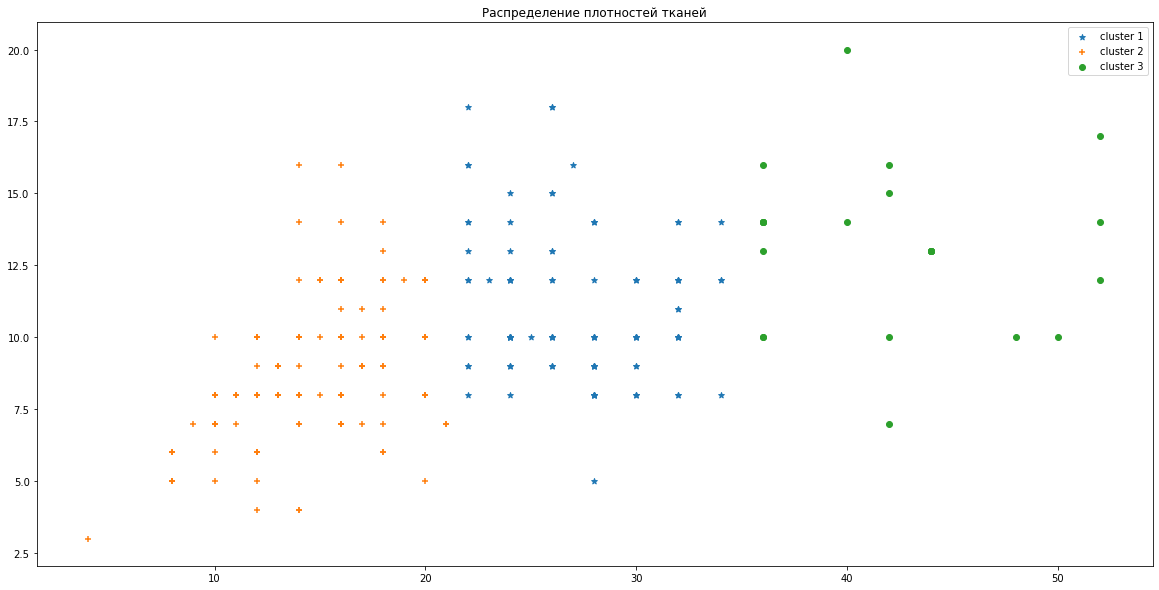

In [27]:
print("\nПОЛНЫЕ ДАННЫЕ (ВКЛЮЧАЯ ВЫБРОСЫ)\n")

_, axes = pyplot.subplots(figsize=[20, 10])
axes.scatter(textiles.query('kmeans_dens == 0')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes.scatter(textiles.query('kmeans_dens == 1')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes.scatter(textiles.query('kmeans_dens == 2')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes.set_title("Распределение плотностей тканей")
axes.legend()
pyplot.show()


ПОЛНЫЕ ДАННЫЕ (2 КЛАСТЕРА, ВКЛЮЧАЯ ВЫБРОСЫ)



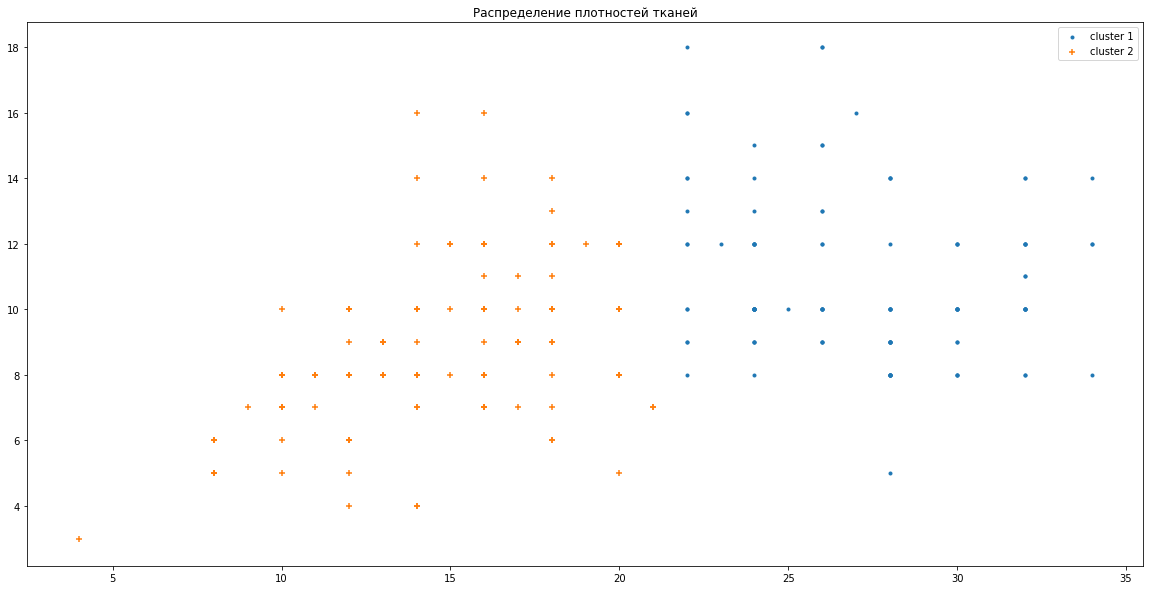

In [28]:
print("\nПОЛНЫЕ ДАННЫЕ (2 КЛАСТЕРА, ВКЛЮЧАЯ ВЫБРОСЫ)\n")

_, axes = pyplot.subplots(figsize=[20, 10])
axes.scatter(textiles.query('kmeans_dens_2 == 0')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens_2 == 0')['weft_dens'].tolist(), marker='.', label="cluster 1")
axes.scatter(textiles.query('kmeans_dens_2 == 1')['warp_dens'].tolist(),
                         textiles.query('kmeans_dens_2 == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes.set_title("Распределение плотностей тканей")
axes.legend()
pyplot.show()



ДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ (3 КЛАСТЕРА)



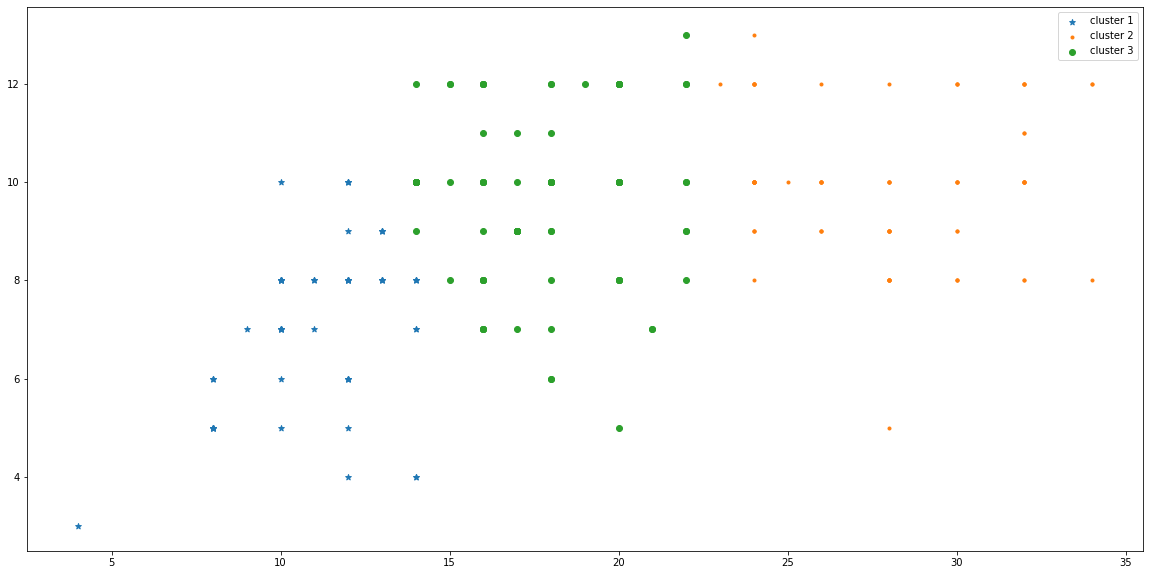

In [29]:
print("\n\nДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ (3 КЛАСТЕРА)\n")
_, axes = pyplot.subplots(figsize=[20, 10])
axes.scatter(textiles_cleared.query('kmeans_dens == 0')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes.scatter(textiles_cleared.query('kmeans_dens == 1')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 1')['weft_dens'].tolist(), marker='.', label="cluster 2")
axes.scatter(textiles_cleared.query('kmeans_dens == 2')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens == 2')['weft_dens'].tolist(), marker='o', label="cluster 3")
axes.legend()
pyplot.show()



ДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ (2 КЛАСТЕРА)



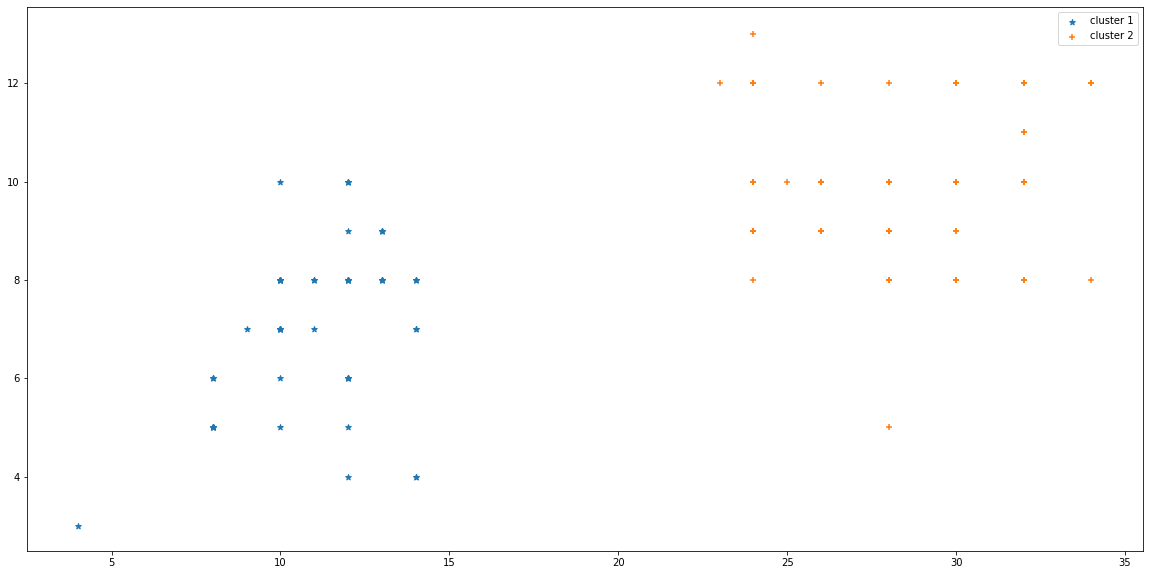

In [30]:
print("\n\nДАННЫЕ С ИСКЛЮЧЁННЫМИ ВЫБРОСАМИ (2 КЛАСТЕРА)\n")
_, axes = pyplot.subplots(figsize=[20, 10])
axes.scatter(textiles_cleared.query('kmeans_dens_2 == 0')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 0')['weft_dens'].tolist(), marker='*', label="cluster 1")
axes.scatter(textiles_cleared.query('kmeans_dens_2 == 1')['warp_dens'].tolist(),
                         textiles_cleared.query('kmeans_dens_2 == 1')['weft_dens'].tolist(), marker='+', label="cluster 2")
axes.legend()
pyplot.show()

### #1 Отличаются ли пелены от бинтов по параметрам?
### #2 Отличаются ли узкие, средние и широкие бинты

In [31]:

# датафрейм - только узкие бинты;
narrow_bands = textiles[textiles['type'] == 'n_band']

########################################################################################################################

# датафрейм - только средние бинты;
middle_bands = textiles[textiles['type'] == 'm_band']

########################################################################################################################

# датафрейм - только широкие бинты;
wide_bands = textiles[textiles['type'] == 'w_band']

########################################################################################################################

# датафрейм - бинты всех типов;
bands = pandas.concat([narrow_bands, middle_bands, wide_bands])

########################################################################################################################

shrouds = textiles[textiles['type'] == 'funeral_shroud']

########################################################################################################################


In [32]:
# Проценты типов бинтов от общего количества тканей

########################################################################################################################

# процент узких бинтов - от общего количества тканей;
narrow_bands_percent_textiles = round((len(narrow_bands) / len(textiles)) * 100, 2)
# процент средних ьинтов - от общего количества тканей;
middle_bands_percent_textiles = round((len(middle_bands) / len(textiles)) * 100, 2)
# процент широких бинтов - от общего количества тканей;
wide_bands_percent_textiles = round((len(wide_bands) / len(textiles)) * 100, 2)
# процент всех бинтов - от общего количества тканей;
bands_percent = round((len(bands) / len(textiles)) * 100, 2)
# Процент погребальных пелен - от общего количества тканей
shrouds_percent = round((len(shrouds) / len(textiles)) * 100, 2)

########################################################################################################################


In [33]:
# Проценты типов бинтов от общего количества бинтов

########################################################################################################################

narrow_bands_percent_bands = round((len(narrow_bands) / len(bands)) * 100, 2)
middle_bands_percent_bands = round((len(middle_bands) / len(bands)) * 100, 2)
wide_bands_percent_bands = round((len(wide_bands) / len(bands)) * 100, 2)

########################################################################################################################


In [34]:

# Толщина нитей и плотность тканей - медиана и среднее -  для узких бинтов

nbands_warp_thick_mean = round(narrow_bands['warp_nominal'].mean(), 3)
nbands_warp_thick_median = round(narrow_bands['warp_nominal'].median(), 3)
nbands_weft_thick_mean = round(narrow_bands['weft_nominal'].mean(), 3)
nbands_weft_thick_median = round(narrow_bands['weft_nominal'].median(), 3)
nbands_warp_dens_mean = round(narrow_bands['warp_dens'].mean(), 3)
nbands_warp_dens_median = round(narrow_bands['warp_dens'].median(), 3)
nbands_weft_dens_mean = round(narrow_bands['weft_dens'].mean(), 3)
nbands_weft_dens_median = round(narrow_bands['weft_dens'].median(), 3)

########################################################################################################################

# Толщина нитей и плотность тканей - медиана и среднее -  для средних бинтов

mbands_warp_thick_mean = round(middle_bands['warp_nominal'].mean(), 3)
mbands_warp_thick_median = round(middle_bands['warp_nominal'].median(), 3)
mbands_weft_thick_mean = round(middle_bands['weft_nominal'].mean(), 3)
mbands_weft_thick_median = round(middle_bands['weft_nominal'].median(), 3)
mbands_warp_dens_mean = round(middle_bands['warp_dens'].mean(), 3)
mbands_warp_dens_median = round(middle_bands['warp_dens'].median(), 3)
mbands_weft_dens_mean = round(middle_bands['weft_dens'].mean(), 3)
mbands_weft_dens_median = round(middle_bands['weft_dens'].median(), 3)

########################################################################################################################

# Толщина нитей и плотность тканей - медиана и среднее -  для широкий бинтов

wbands_warp_thick_mean = round(wide_bands['warp_nominal'].mean(), 3)
wbands_warp_thick_median = round(wide_bands['warp_nominal'].median(), 3)
wbands_weft_thick_mean = round(wide_bands['weft_nominal'].mean(), 3)
wbands_weft_thick_median = round(wide_bands['weft_nominal'].median(), 3)
wbands_warp_dens_mean = round(wide_bands['warp_dens'].mean(), 3)
wbands_warp_dens_median = round(wide_bands['warp_dens'].median(), 3)
wbands_weft_dens_mean = round(wide_bands['weft_dens'].mean(), 3)
wbands_weft_dens_median = round(wide_bands['weft_dens'].median(), 3)

########################################################################################################################


In [35]:

########################################################################################################################

#

shrouds_thick_mean_warp = round(shrouds['warp_nominal'].mean(), 3)
shrouds_thick_mean_weft = round(shrouds['weft_nominal'].mean(), 3)
shrouds_dens_mean_warp = round(shrouds['warp_dens'].mean(), 3)
shrouds_dens_mean_weft = round(shrouds['weft_dens'].mean(), 3)

########################################################################################################################


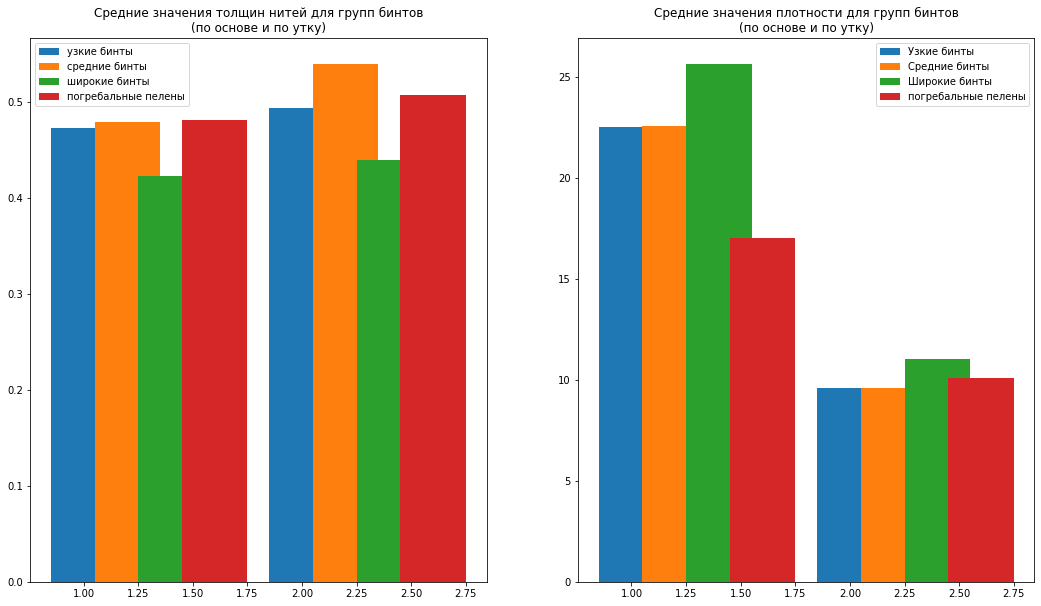


Узких бинтов - 94
Средних бинтов - 81
Широких бинтов - 19
Всего бинтов - 194

Процент узких бинтов (от общего количества тканей) - 31.02
Процент средних бинтов (от общего количества тканей) - 26.73
Процент широких бинтов ( от общего количества тканей) - 6.27

Процент узких бинтов (от общего количества бинтов) - 48.45
Процент средних бинтов (от общего количества бинтов) - 41.75
Процент щироких бинтов (от общего количества бинтов) - 9.79

Процент бинтов (от общего количества тканей) - 64.03

Узкие бинты:
Толщина по основе - среднее значение - 0.472
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.493
Толщина по утку - медиана - 0.5

Плотность по основе - среднее значение - 22.532
Плотность по основе - медиана - 22.0
Плотность по утку - среднее значение - 9.617
Плотность по утку - медиана - 9.0

Средние бинты:
Толщина по основе - среднее значение - 0.479
Толщина по основе - медиана - 0.45
Толщина по утку - среднее значение - 0.539
Толщина по утку - медиана - 0.5


In [36]:

# Парный график - толщины нитей и плотности тканей для групп бинтов

ax, axes = pyplot.subplots(nrows=1, ncols=2, figsize=[18, 10])
axes[0].set_title('Средние значения толщин нитей для групп бинтов\n(по основе и по утку)')
axes[0].bar((1, 2), (nbands_warp_thick_mean, nbands_weft_thick_mean), width=0.3, label='узкие бинты')
axes[0].bar((1.2, 2.2), (mbands_warp_thick_mean, mbands_weft_thick_mean), width=0.3, label='средние бинты')
axes[0].bar((1.4, 2.4), (wbands_warp_thick_mean, wbands_weft_thick_mean), width=0.3, label='широкие бинты')
axes[0].bar((1.6, 2.6), (shrouds_thick_mean_warp, shrouds_thick_mean_weft), width=0.3, label='погребальные пелены')
axes[0].legend()
axes[1].set_title('Средние значения плотности для групп бинтов\n(по основе и по утку)')
axes[1].bar((1, 2), (nbands_warp_dens_mean, nbands_weft_dens_mean), width=0.3, label='Узкие бинты')
axes[1].bar((1.2, 2.2), (mbands_warp_dens_mean, mbands_weft_dens_mean), width=0.3, label='Средние бинты')
axes[1].bar((1.4, 2.4), (wbands_warp_dens_mean, wbands_weft_dens_mean), width=0.3, label='Широкие бинты')
axes[1].bar((1.6, 2.6), (shrouds_dens_mean_warp, shrouds_dens_mean_weft), width=0.3, label='погребальные пелены')
axes[1].legend()
print()
print()
pyplot.show()

########################################################################################################################

# Вывод текстовой информации

print()
print("Узких бинтов - " + str(len(narrow_bands)))
print("Средних бинтов - " + str(len(middle_bands)))
print("Широких бинтов - " + str(len(wide_bands)))
print("Всего бинтов - " + str(len(bands)))
print()

########################################################################################################################

print("Процент узких бинтов (от общего количества тканей) - " + str(narrow_bands_percent_textiles))
print("Процент средних бинтов (от общего количества тканей) - " + str(middle_bands_percent_textiles))
print("Процент широких бинтов ( от общего количества тканей) - " + str(wide_bands_percent_textiles))

########################################################################################################################

print()
print("Процент узких бинтов (от общего количества бинтов) - " + str(narrow_bands_percent_bands))
print("Процент средних бинтов (от общего количества бинтов) - " + str(middle_bands_percent_bands))
print("Процент щироких бинтов (от общего количества бинтов) - " + str(wide_bands_percent_bands))

########################################################################################################################

print()
print("Процент бинтов (от общего количества тканей) - " + str(bands_percent))

########################################################################################################################

print()
print("Узкие бинты:")
print("Толщина по основе - среднее значение - " + str(nbands_warp_thick_mean))
print('Толщина по основе - медиана - ' + str(nbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(nbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(nbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(nbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(nbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(nbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(nbands_weft_dens_median))

########################################################################################################################

print()
print("Средние бинты:")
print("Толщина по основе - среднее значение - " + str(mbands_warp_thick_mean))
print("Толщина по основе - медиана - " + str(mbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(mbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(mbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(mbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(mbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(mbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(mbands_weft_dens_median))

########################################################################################################################

print()
print("Широкие бинты:")
print("Толщина по основе - среднее значение - " + str(wbands_warp_thick_mean))
print("Толщина по основе - медиана - " + str(wbands_warp_thick_median))
print("Толщина по утку - среднее значение - " + str(wbands_weft_thick_mean))
print("Толщина по утку - медиана - " + str(wbands_weft_thick_median))
print()
print("Плотность по основе - среднее значение - " + str(wbands_warp_dens_mean))
print("Плотность по основе - медиана - " + str(wbands_warp_dens_median))
print("Плотность по утку - среднее значение - " + str(wbands_weft_dens_mean))
print("Плотность по утку - медиана - " + str(wbands_weft_dens_median))

########################################################################################################################

print()
print("Погребальные пелены:")
print("Плотность по основе - среднее значение - " + str(shrouds_dens_mean_warp))
print("Плотность по утку - среднее значение - " + str(shrouds_dens_mean_weft))
print("Толщина нити по основе - среднее значение - " + str(shrouds_thick_mean_warp))
print("Толщина нити по утку - среднее значение - " + str(shrouds_thick_mean_weft))

########################################################################################################################

### #3 Каков процент рогожки?

### #4 Какие группы тканей по качеству получаются?

#### #4.1 Ткани с высокой плотностью по основе

##### #4.1.1 Проверка тенденции к сбалансированности у тканей с высокой плотностью по основе

In [37]:

########################################################################################################################

def proportion(x, y):
    return round(x / y, 2)

########################################################################################################################

high_density_warp = textiles.query("warp_dens >= 20").copy()
high_density_warp['warp_weft'] = high_density_warp.apply(lambda x: proportion(x['warp_dens'], x['weft_dens']), axis = 1)
print("Всего тканей с высокой плотностью по основе (более или равно 20) - " + str(len(high_density_warp)))
# high_density_warp['warp_weft'].plot.hist(color='green', alpha=0.5,
#                                          title='Гистограмма соотношений плотностей по основе и утку для'
#                                                ' тканей с высокой плотностью по основе', figsize=[8, 8], bins=30)

########################################################################################################################


Всего тканей с высокой плотностью по основе (более или равно 20) - 156


##### #4.1.2 Проверка тенденции к сбалансированности у тканей с умеренной плотностью по основе

In [38]:
low_density_warp = textiles.query("warp_dens < 20").copy()
low_density_warp['warp_weft'] = low_density_warp.apply(lambda x: proportion(x['warp_dens'], x['weft_dens']), axis = 1)
print("Всего тканей с низкой и умеренной плотностью по основе (менее 20) - " + str(len(low_density_warp)))
# low_density_warp['warp_weft'].plot.hist(color='green', alpha=0.5, title='',figsize=[8, 8], bins=30)

Всего тканей с низкой и умеренной плотностью по основе (менее 20) - 147


In [39]:
# low_density_warp['warp_weft'].plot.kde(color='red', figsize=[8, 8],
# title='warp/weft для тканей с низкой плотностью по основе')

### #5 Различаются ли нити основы и нити утка?

### #11 Разделить ткани по сбалансированности (сбалансированные - ±3 нити; ткани с преобладанием нитей основы); рассчитать процент каждой группы

In [40]:
balanced = textiles.query("(warp_dens <= (weft_dens + 3)) & (warp_dens >= (weft_dens - 3))")
unbalanced = len(textiles) - len(balanced)

print('Общее количество сбалансированных тканей - ' + str(len(balanced)))
print('Общее количество несбалнсированных тканей - ' + str(unbalanced))

balanced_percent = len(balanced) / len(textiles) * 100
print("Процент сбалансированных тканей - " + str(balanced_percent))
print("" + str(100 - balanced_percent))

Общее количество сбалансированных тканей - 47
Общее количество несбалнсированных тканей - 256
Процент сбалансированных тканей - 15.51155115511551
84.48844884488449
